<a href="https://colab.research.google.com/github/mirjanaa/Bee-Colony-Optimization/blob/main/genetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic algorithm

<a href="https://colab.research.google.com/github/mirjanaa/Bee-Colony-Optimization/blob/main/genetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import copy

In [2]:
class Individual:

  def __init__(self, bounds, obj_function, individual):
    self.code = individual.position
    self.obj_value = obj_function(self.code)
    self.fitness = self.calc_fitness()

  def __lt__(self, other):
    return self.fitness < other.fitness


  def calc_fitness(self):
    return 1 / (1 + self.obj_value)


In [3]:
bounds = np.array([(-5.12, 5.12), (-5.12, 5.12)])

In [4]:
def rastrigin(x):
    A = 10
    n = len(x)
    return A*n + sum(x_i**2 - A*np.cos(2*np.pi*x_i) for x_i in x)

In [5]:
def selection(population, tournament_size):
  TOURNAMENT_SIZE = tournament_size
  bestFitness = float('-inf')
  index = -1
  for i in range(TOURNAMENT_SIZE):
      randomIndividual = random.randrange(len(population))
      if population[randomIndividual].fitness > bestFitness:
          bestFitness = population[randomIndividual].fitness
          index = randomIndividual
  return index 

In [6]:
def crossover(parent1, parent2, child1, child2):

  for i in range(len(parent1.code)):
    child1.code[i] = (parent1.code[i] + parent2.code[i]) / 2
    if random.random() < 0.5:
      child2.code[i] = parent1.code[i]
    else:
      child2.code[i] = parent2.code[i]

  if child1.calc_fitness() < parent1.fitness and child1.calc_fitness() < parent2.fitness and child2.calc_fitness() < parent1.fitness and child2.calc_fitness() < parent2.fitness:
    child1.code = parent1.code
    child2.code = parent2.code


In [7]:
def mutation(individual):
  MUTATION_PROB = 0.05
  for i in range(len(individual.code)):
      if random.random() < MUTATION_PROB:
          individual.code[i] = random.uniform(bounds[i][0], bounds[i][1])

In [8]:
def genetic_algorithm(population_size, generation_size, tournament_size, obj_function, initial_population):

  POPULATION_SIZE = population_size
  GENERATION_SIZE = generation_size
  ELITISIM_SIZE = POPULATION_SIZE // 5
  TOURNAMENT_SIZE = tournament_size

  population = [Individual(bounds, obj_function, initial_population[i]) for i in range(POPULATION_SIZE)]
  new_population = [Individual(bounds, obj_function, initial_population[i]) for i in range(POPULATION_SIZE)]

  fitness_values = []
  obj_values = []

  for i in range(GENERATION_SIZE):
    population.sort(reverse=True)
    new_population[:ELITISIM_SIZE] = population[:ELITISIM_SIZE]

    fitness_values.append(population[0].fitness)
    obj_values.append(population[0].obj_value)

    for j in range(ELITISIM_SIZE, POPULATION_SIZE, 2):
      index_parent1 = selection(population, TOURNAMENT_SIZE)
      index_parent2 = selection(population, TOURNAMENT_SIZE)

      crossover(population[index_parent1], population[index_parent2], new_population[j], new_population[j+1])

      mutation(new_population[j])
      mutation(new_population[j+1])

      new_population[j].fitness = new_population[j].calc_fitness()
      new_population[j+1].fitness = new_population[j+1].calc_fitness()

    population = new_population

  best_individual = max(population) 

  print("Genetski algoritam: ")
  print(f"Best individual: {best_individual.code}, obj_value: {best_individual.obj_value}")

  return best_individual, obj_values, fitness_values






## ABC algorithm


In [9]:
import random
import numpy as np
from matplotlib import pyplot as plt




class FoodSource:
  def __init__(self, bounds, obj_function):
    self.position = np.array([random.uniform(bound[0], bound[1]) for bound in bounds])
    self.obj_value = obj_function(self.position)
    self.fitness = self.calculate_fitness()
    self.trial = 0
    self.probability = 0


  def __lt__(self, other):
    return self.obj_value < other.obj_value

  def __gt__(self, other):
    return self.fitness > other.fitness

  def calculate_fitness(self):
    if self.obj_value >= 0:
      return 1 / (1 + self.obj_value)
    return 1 + abs(self.obj_value) 
    
    
bounds = np.array([(-5.12, 5.12), (-5.12, 5.12)])



def generate_new_solution(i, population, lb, ub, obj_function):

  j = random.randrange(len(bounds))
  partner = random.randrange(len(population))

  while i == partner:
    partner = random.randrange(len(population))

  phi = random.uniform(-1, 1)

  old_fitness = population[i].fitness
  old_objective_value = population[i].obj_value

  old_j = population[i].position[j]
  new_j = population[i].position[j] + phi * (population[i].position[j] - population[partner].position[j])

  population[i].position[j] = new_j
  population[i].position[j] = np.clip(population[i].position[j], lb[j], ub[j])
  
  new_objective_value = obj_function(population[i].position)
   
  population[i].obj_value = new_objective_value
  population[i].fitness = population[i].calculate_fitness()

  if population[i].fitness > old_fitness:
    population[i].trial = 0
  
  else:
    population[i].position[j] = old_j
    population[i].obj_value = old_objective_value
    population[i].fitness = old_fitness
    population[i].trial = population[i].trial + 1 

    
    
    
def ABC_algorithm(population_size, num_of_iters, limit, obj_function):

  POPULATION_SIZE = population_size
  NUM_OF_ITERATIONS = num_of_iters
  LIMIT = limit

  lower_bound = np.array([x[0] for x in bounds])
  upper_bound = np.array([x[1] for x in bounds])


  population = [FoodSource(bounds, obj_function) for _ in range(POPULATION_SIZE)]
  initial_population = copy.deepcopy(population)

  best_solution = min(population)

  obj_values = []
  fitness_values = []

  for k in range(NUM_OF_ITERATIONS):
    #### Employed Bee Phase ####
    for i in range(POPULATION_SIZE):
      generate_new_solution(i, population, lower_bound, upper_bound, obj_function)

    #### Onlooker Bee Phase ####
    max_fitness = max([population[i].fitness for i in range(POPULATION_SIZE)])
    for i in range(POPULATION_SIZE):
      population[i].probability = 0.9 * (population[i].fitness / max_fitness) + 0.1


    m = 0
    n = 0

    while m < POPULATION_SIZE and n < POPULATION_SIZE:
      rand_value = random.uniform(0, 1)
      if rand_value < population[n].probability:
        generate_new_solution(n, population, lower_bound, upper_bound, obj_function)
        m += 1
      n = (n % POPULATION_SIZE) + 1

    best_solution = min(min(population), best_solution)

    #### Scout Bee Phase ####
    max_index = -1
    max_trial = float('-inf')
    for index, p in enumerate(population):
      if p.trial > max_trial:
        max_trial = p.trial
        max_index = index


    if population[max_index].trial > LIMIT:
      population[max_index] = FoodSource(bounds, obj_function)

    best_solution = min(min(population), best_solution)

    obj_values.append(best_solution.obj_value)
    fitness_values.append(best_solution.fitness)

  print("ABC algoritam: ")
  print("position: ", [i for i in best_solution.position])
  print("objective value: ", best_solution.obj_value)
  print("fitness value: ", best_solution.fitness)

  return best_solution, obj_values, fitness_values, initial_population
    
    
    

## Comparison between genetic and ABC algorithm

ABC algoritam: 
position:  [0.053003870015766404, -0.0295750372788032]
objective value:  0.7252920400831329
fitness value:  0.5796120174250704
Genetski algoritam: 
Best individual: [-0.41688177  1.1125427 ], obj_value: 20.131155323482716
ABC algoritam: 
position:  [-1.1271451006588443e-09, -3.0471606744524555e-09]
objective value:  0.0
fitness value:  1.0
Genetski algoritam: 
Best individual: [-0.8980579   0.36406574], obj_value: 2.7552215428758444
ABC algoritam: 
position:  [1.344077503580648e-09, 1.3350030812815076e-09]
objective value:  0.0
fitness value:  1.0
Genetski algoritam: 
Best individual: [-1.25751145 -2.28221621], obj_value: 1.2927712862502148
ABC algoritam: 
position:  [4.4209957982531325e-11, -3.5389868694028235e-09]
objective value:  0.0
fitness value:  1.0
Genetski algoritam: 
Best individual: [ 0.60709027 -0.60939814], obj_value: 1.1121106099288838
ABC algoritam: 
position:  [-0.016533206506462894, 0.9204611578285963]
objective value:  2.124441103871778
fitness value:

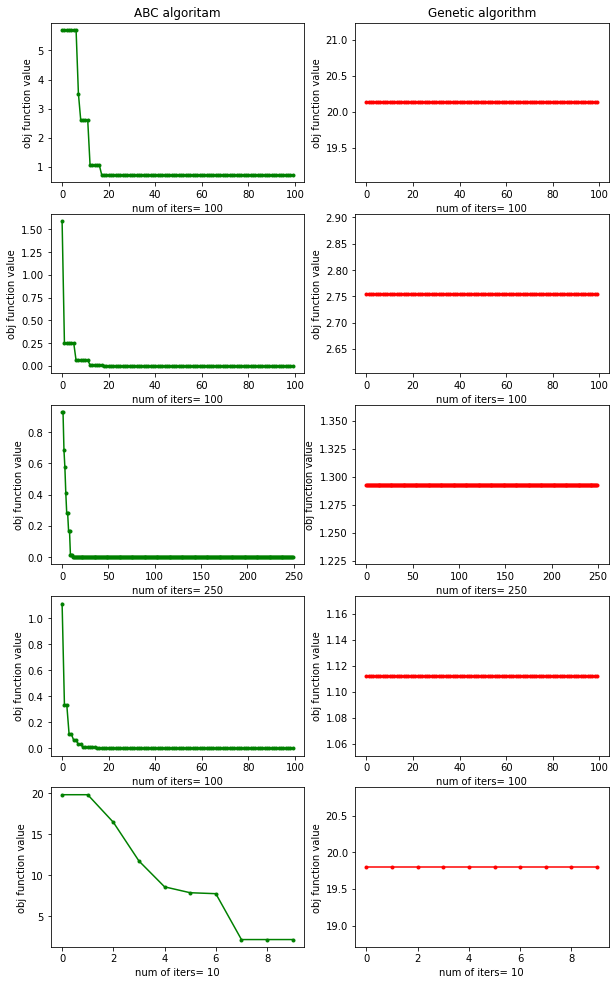

In [10]:
population_size = [10, 100, 1000]
num_iters = [10, 100, 250]
limit = [2, 5]

tmp=5

plt.figure(figsize=(10, 17))

p = random.sample(population_size, k=1)[0]
n = random.sample(num_iters, k=1)[0]
l = random.sample(limit, k=1)[0]
t = random.sample(range(10), k=1)[0]

_, obj_values, fitness, initial_population = ABC_algorithm(p, n, l, rastrigin)
plt.subplot(tmp, 2, 1)
plt.plot(range(n), obj_values, color='green', marker='.')
plt.xlabel("num of iters= " + str(n))
plt.ylabel("obj function value")
plt.title('ABC algoritam')

_, obj_values, fitness = genetic_algorithm(p, n, t, rastrigin, initial_population)
plt.subplot(tmp, 2, 2)
plt.plot(range(n), obj_values, color='red', marker='.')
plt.xlabel("num of iters= " + str(n))
plt.ylabel("obj function value")
plt.title('Genetic algorithm')

for i in range(1, tmp):
  p = random.sample(population_size, k=1)[0]
  n = random.sample(num_iters, k=1)[0]
  l = random.sample(limit, k=1)[0]

  _, obj_values, fitness, initial_population = ABC_algorithm(p, n, l, rastrigin)
  plt.subplot(tmp, 2, 2*i+1)
  plt.plot(range(n), obj_values, color='green', marker='.')
  plt.xlabel("num of iters= " + str(n))
  plt.ylabel("obj function value")

  best_solution, obj_values, fitness = genetic_algorithm(p, n, t, rastrigin, initial_population)
  plt.subplot(tmp, 2, 2*i+2)
  plt.plot(range(n), obj_values, color='red', marker='.')
  plt.xlabel("num of iters= " + str(n))
  plt.ylabel("obj function value")

plt.show()